In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import keras
from models import model_v1, model_v2
tf.test.is_gpu_available()

2024-02-28 18:45:25.704886: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 18:45:25.732009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 18:45:25.732067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 18:45:25.732740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 18:45:25.737978: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-02-28 18:45:26.784596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 18:45:26.812476: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 18:45:26.816751: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

In [3]:
# dataset
from pathlib import Path
from DataGenerator import DataGenerator

# training set data generator
root = "/home/ji/Dropbox/Robotics/CMSC733/Project1"
rho = 32
train_path = Path(root) / "Phase2" / "Data" / "Train_Resize"
train_gen = DataGenerator(train_path,mode="supervised",
                          rho=rho)

# validation set
val_path = Path(root) / "Phase2" / "Data" / "Val_Resize"
val_gen = DataGenerator(val_path,mode="supervised",
                        rho=rho)


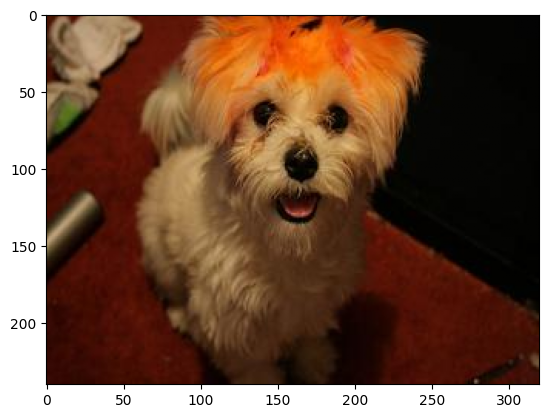

[[  0   0]
 [127   0]
 [127 127]
 [  0 127]]
[[-15  23]
 [138 -19]
 [131 150]
 [ -4 143]]
[ 15 -23 -11  19  -4 -23   4 -16]
[[ 8.70238306e-01  3.84611067e-01 -2.70427905e+01]
 [-1.63588766e-01  1.28241907e+00  1.73030211e+01]
 [-1.10938244e-03  2.44493762e-03  1.00000000e+00]]
[52 53] [52. 53.]
[179  53] [179.  53.]
[179 180] [179. 180.]
[ 52 180] [ 52. 180.]
(128, 128, 3) (128, 128, 3) (8,)


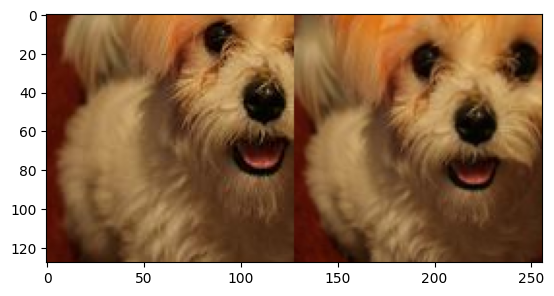

In [20]:
# test generator
sample_input, sample_output = next(train_gen(debug=True))
print(sample_input[0].shape,sample_input[1].shape,sample_output.shape)

In [5]:
# tensorflow dataset
im_shape = (train_gen.crop_size,train_gen.crop_size,3)
output_signature = ((tf.TensorSpec(shape=im_shape,dtype=tf.float32),
                     tf.TensorSpec(shape=im_shape,dtype=tf.float32)),
                     tf.TensorSpec(shape = (8,),dtype=tf.float32),
                    )
train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen,
                                          output_signature=output_signature)

batch_size=16
def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds

train_ds = config_ds(train_ds)
val_ds = config_ds(val_ds)

# loss function
def custom_loss(y_true, y_pred):
    return 0.5*tf.reduce_mean(tf.square(y_true-y_pred))

def metric_abs(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true-y_pred))

def metric_dist(y_true, y_pred):
    """compute the l2 distance between corner

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_
    """
    d = tf.reshape(y_true,(-1,4,2))-tf.reshape(y_pred,(-1,4,2))
    return tf.reduce_mean(tf.norm(d,ord='euclidean',axis=-1))

In [8]:
# model version 2
model = model_v2(verbose=True)
model.load_weights('./chkpt_weight/checkpoint_mdl_v2_rho16')

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=custom_loss, metrics=[metric_abs,metric_dist])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        (None, 32, 32, 256)          2325568   ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 concatenate_1 (Concatenate  (None, 32, 32, 512)          0         ['model_2[0][0]',       

In [10]:
model.optimizer.learning_rate = 1e-3

In [11]:
import numpy as np
steps_per_epoch = int(np.floor(5000/batch_size))

# reduce learning rate on plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                factor=0.2,
                                                patience=5,
                                                min_lr=1e-6,
                                                verbose=1,
                                                cooldown=5)

# save check points
checkpoint_filepath = f'./chkpt_weight/checkpoint_mdl_v2_rho{rho:2d}'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only = True,
    verbose=True,
    # save_freq = steps_per_epoch*10
    )

history = model.fit(train_ds,validation_data=val_ds,
                    validation_steps=int(np.floor(1000/batch_size)),
                    validation_freq=1,
                    epochs=150,verbose=True,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[reduce_lr,checkpoint_callback])

Epoch 1/150
312/312 [==============================] - ETA: 0s - loss: 58.0156 - metric_abs: 8.2118 - metric_dist: 12.8871reshuffling dataset

Epoch 1: val_loss improved from inf to 69.53220, saving model to ./chkpt_weight/checkpoint_mdl_v2_rho32
312/312 [==============================] - 49s 126ms/step - loss: 58.0156 - metric_abs: 8.2118 - metric_dist: 12.8871 - val_loss: 69.5322 - val_metric_abs: 9.0515 - val_metric_dist: 14.3411 - lr: 0.0010
Epoch 2/150
312/312 [==============================] - ETA: 0s - loss: 42.5766 - metric_abs: 6.9991 - metric_dist: 11.0154reshuffling dataset

Epoch 2: val_loss improved from 69.53220 to 32.51928, saving model to ./chkpt_weight/checkpoint_mdl_v2_rho32
312/312 [==============================] - 38s 123ms/step - loss: 42.5766 - metric_abs: 6.9991 - metric_dist: 11.0154 - val_loss: 32.5193 - val_metric_abs: 6.0414 - val_metric_dist: 9.5085 - lr: 0.0010
Epoch 3/150
312/312 [==============================] - ETA: 0s - loss: 40.2760 - metric_abs: 6.7

KeyboardInterrupt: 

reshuffling dataset


In [12]:
# reduce learning rate on plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                factor=0.2,
                                                patience=5,
                                                min_lr=1e-8,
                                                verbose=1,
                                                cooldown=5)

# save check points
checkpoint_filepath = f'./chkpt_weight/checkpoint_mdl_v2_rho{rho:2d}'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only = True,
    verbose=True,
    # save_freq = steps_per_epoch*10
    )

history = model.fit(train_ds,validation_data=val_ds,
                    validation_steps=int(np.floor(1000/batch_size)),
                    validation_freq=1,
                    epochs=150,verbose=True,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[reduce_lr,checkpoint_callback])

Epoch 1/150
312/312 [==============================] - ETA: 0s - loss: 20.5929 - metric_abs: 4.9362 - metric_dist: 7.7770reshuffling dataset

Epoch 1: val_loss improved from inf to 7.21405, saving model to ./chkpt_weight/checkpoint_mdl_v2_rho32
312/312 [==============================] - 40s 127ms/step - loss: 20.5929 - metric_abs: 4.9362 - metric_dist: 7.7770 - val_loss: 7.2140 - val_metric_abs: 2.7976 - val_metric_dist: 4.3930 - lr: 1.0000e-06
Epoch 2/150
312/312 [==============================] - ETA: 0s - loss: 20.8749 - metric_abs: 4.9839 - metric_dist: 7.8446reshuffling dataset

Epoch 2: val_loss did not improve from 7.21405
312/312 [==============================] - 39s 125ms/step - loss: 20.8749 - metric_abs: 4.9839 - metric_dist: 7.8446 - val_loss: 7.4867 - val_metric_abs: 2.8509 - val_metric_dist: 4.4601 - lr: 1.0000e-06
Epoch 3/150
312/312 [==============================] - ETA: 0s - loss: 21.2553 - metric_abs: 5.0338 - metric_dist: 7.9024reshuffling dataset

Epoch 3: val_los

KeyboardInterrupt: 

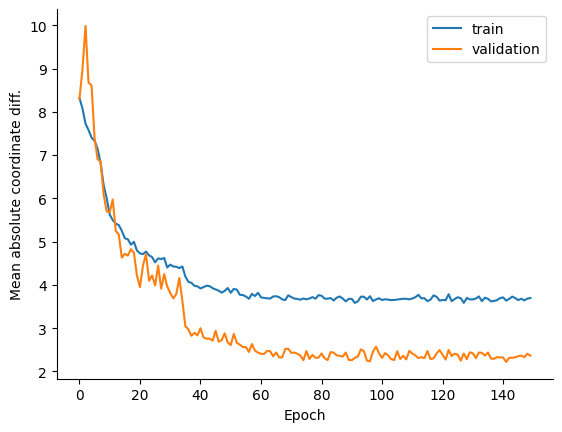

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['metric_abs'])
plt.plot(history.history["val_metric_abs"])
plt.legend(["train","validation"])
plt.xlabel('Epoch')
plt.ylabel('Mean absolute coordinate diff.')
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False) 
plt.show()

## Print some sample output from the trained model

In [6]:
# load model
model = model_v2()
model.load_weights('./chkpt_weight/checkpoint_mdl_v2_rho32')

In [8]:
sample_input, sample_output = next(iter(train_ds))
model_output = model(sample_input)

print(sample_output)
print(tf.round(model_output))

tf.Tensor(
[[ 17. -28. -23. -28. -11. -17. -29. -27.]
 [  0. -18.  19.  23. -20.  25. -30.  -3.]
 [ -8. -15.   3. -16.  -4. -26.  22.  25.]
 [-12.  19.  23.  17.   0.  29.  23. -16.]
 [ 17. -10. -26. -31. -16. -21. -14.   0.]
 [ 28.   1.   2.  27.  -1. -11.  -4. -28.]
 [ 24.   2. -32.  -1.   4.   3.   1. -27.]
 [-11.  23.  17.   8.   8.   4. -14.  23.]
 [-20.   1. -16.  11.  20. -20. -30. -30.]
 [-30.  32. -21. -10.  -5. -30.  17.  20.]
 [-12.  11.   4.  25. -15. -24. -12. -18.]
 [  6.   1.  26.   4.  -8. -12.  13.  20.]
 [ 14.  13.  22.   5. -12.  15. -12. -13.]
 [-31.   1. -19.  19.   9.   3.   1. -26.]
 [ 12.   9. -25.  29.  20.  -9.   8.  32.]
 [-27.  30. -16.  26. -10.  -8. -17.  18.]], shape=(16, 8), dtype=float32)
tf.Tensor(
[[ 20. -27. -21. -17. -10. -18. -29. -25.]
 [ -1. -21.  24.  27. -20.  25. -32.  -8.]
 [ -8. -15.   4. -15.  -1. -24.  17.  22.]
 [-10.  22.  19.  12.   2.  27.  23. -15.]
 [ 18.  -7. -22. -32. -24. -17. -14.  -1.]
 [ 26.   0.   3.  29.  -1. -10.  -7. -24.]
